# Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models

Ovaj skup obuhvaća longitudinalnu zbirku MRI podataka od prvih posjeta 150 pacijenata u dobi od 60 do 98 godina. Svi subjekti su dešnjaci i uključuje 62 muškaraca i 88 žena. 36 muškaraca je dementno od prvog nalaza, 22 nisu, a 4 je dijagnosticirano tijekom ispitivanja. 28 žena je dementno od prvog nalaza, 50 nije, a 10 je dijagnosticirano tijekom ispitivanja.

## Učitavanje podataka

In [561]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.svm import SVC
import seaborn as sns
import seaborn as sns
import pandas as pd
import numpy as np

In [562]:
drive.mount("/content/drive")
X = pd.read_csv("/content/drive/MyDrive/UZOP-PROJEKT/uzop_projekt_ulazni_podaci.csv", sep = ",")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MRI ID je monotoni atribut, a Hand konstantan atribut. Izbacimo atribute MRI ID i Hand iz skupa podataka.

In [563]:
X.drop(('MRI ID'), axis=1, inplace=True)
X.drop(('Hand'), axis=1, inplace=True)

Izostavili smo značajku MR Delay jer je ista vrijednost zabilježena za sve prve posjete.

In [564]:
X.drop(('MR Delay'), axis=1, inplace=True)
X.drop(('Subject ID'), axis=1, inplace=True)
X = X[(X['Visit'] == 1)]
X.drop(('Visit'), axis=1, inplace=True)
X = X[(X['Group'] != 'Converted')]
X.describe()

,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,136.000000,136.000000,128.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,75.279412,14.470588,2.562500,27.375000,0.283088,1478.147059,0.735897,1.203956
std,7.539222,2.905783,1.120672,3.045184,0.331675,178.402771,0.036902,0.140625
min,60.000000,6.000000,1.000000,17.000000,0.000000,1123.000000,0.660000,0.883000
25%,70.000000,12.000000,2.000000,26.000000,0.000000,1349.750000,0.708500,1.116250
50%,75.000000,14.000000,2.000000,29.000000,0.000000,1459.000000,0.736500,1.203500
75%,80.000000,16.000000,3.250000,30.000000,0.500000,1571.750000,0.758250,1.300250
max,96.000000,23.000000,5.000000,30.000000,1.000000,1987.000000,0.837000,1.563000


Sada imamo novi problem s podatcima - nedostajući podatci.

In [565]:
X.isna().sum()

Group    0
M/F      0
Age      0
EDUC     0
SES      8
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

Mi ćemo ubaciti srednju vrijednost socioekonomskog statusa tamo gdje nedostaje ta informacija.

In [566]:
X.loc[X.SES.isna(),'SES'] = X.loc[:,'SES'].mean()

Transformirali smo podatke primjenjujući numeričke oznake za kategorije. Na primjer, za spol, vrijednost 0 predstavlja ženski spol, dok vrijednost 1 predstavlja muški spol. Također, dementnu grupu označili smo brojem 0, a nedementnu s 1.

In [567]:
le = LabelEncoder()
le.fit(X.loc[:,'Group'])
X.loc[:,'Group'] = le.transform(X.loc[:,'Group'])
le.fit(X.loc[:,'M/F'])
X.loc[:,'M/F'] = le.transform(X.loc[:,'M/F'])
X.head()

<ipython-input-567-4995dd301cec>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,'Group'] = le.transform(X.loc[:,'Group'])
<ipython-input-567-4995dd301cec>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,'M/F'] = le.transform(X.loc[:,'M/F'])


,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,1,87,14,2.0000,27.0,0.0,1987,0.696,0.883
2,0,1,75,12,2.5625,23.0,0.5,1678,0.736,1.046
5,1,0,88,18,3.0000,28.0,0.0,1215,0.710,1.444
7,1,1,80,12,4.0000,28.0,0.0,1689,0.712,1.039
10,0,1,71,16,2.5625,28.0,0.5,1357,0.748,1.293


## Replikacija rezultata

In [568]:
print(X)

     Group  M/F  Age  EDUC     SES  MMSE  CDR  eTIV   nWBV    ASF
0        1    1   87    14  2.0000  27.0  0.0  1987  0.696  0.883
2        0    1   75    12  2.5625  23.0  0.5  1678  0.736  1.046
5        1    0   88    18  3.0000  28.0  0.0  1215  0.710  1.444
7        1    1   80    12  4.0000  28.0  0.0  1689  0.712  1.039
10       0    1   71    16  2.5625  28.0  0.5  1357  0.748  1.293
..     ...  ...  ...   ...     ...   ...  ...   ...    ...    ...
359      0    1   73    12  2.5625  23.0  0.5  1661  0.698  1.056
361      1    0   66    13  2.0000  30.0  0.0  1495  0.746  1.174
365      0    0   72    16  3.0000  24.0  0.5  1354  0.733  1.296
367      0    1   80    16  1.0000  28.0  0.5  1704  0.711  1.030
370      1    0   61    13  2.0000  30.0  0.0  1319  0.801  1.331

[136 rows x 10 columns]


Izgradnja modela strojnog učenja zahtijeva podjelu podataka na skupove za treniranje i testiranje. Model je učen na podacima za treniranje, dok su podaci za testiranje korišteni za ispitivanje neviđenih podataka. Unakrsna validacija provedena je dijeljenjem skupa podataka na tri podskupa. Predviđanja modela izrađuju se korištenjem jednog podskupa podataka (testni podaci), a performanse modela procjenjuju se korištenjem drugih podskupova (podaci za treniranje i validaciju). Podaci su prethodno obrađeni, te smo ih nasumično podijelili u omjeru 80:20, gdje 80% ide na treniranje, a 20% na testiranje.

In [569]:
selected_data = X[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]
y = X['Group']
X_train, X_test, Y_train, Y_test = train_test_split(selected_data, y, test_size=0.2, random_state=42)

Procjenjujemo različite metrike performansi poput točnosti, preciznosti, odziva i F1 ocjene. Kako bismo odredili najbolje parametre za svaki model, provodimo 10-erostruku unakrsnu validaciju za: Decision Tree, SVM, Random Forests, XGBoost i Voting. Na kraju, uspoređujemo točnost svakog modela. Odziv ili osjetljivost predstavlja proporciju ljudi koji su točno klasificirani kao osobe s Alzheimerovom bolešću. Preciznost dijagnoze Alzheimerove bolesti je stopa osoba koje su točno klasificirane kao osobe koje nemaju bolest. F1 ocjena uzima u obzir i parametre odziva i preciznosti, dok točnost predstavlja proporciju osoba koje su točno klasificirane.

In [570]:
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
xgb_model = XGBClassifier(random_state=42)
voting_model = VotingClassifier(estimators=[
    ('dt', dt_model),
    ('rf', rf_model),
    ('svm', svm_model),
    ('xgb', xgb_model)
], voting='soft')

models = [dt_model, rf_model, svm_model, xgb_model, voting_model]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']
results_dict = {'Model': [], 'Test Accuracy': [], 'Test Precision': [], 'Test Recall': [], 'Test F1 Score': []}

for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring='accuracy')
    print(f"{name}")
    print(f"Mean Accuracy: {scores.mean()}")
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions, average='weighted', zero_division=1)
    recall = recall_score(Y_test, predictions, average='weighted', zero_division=1)
    f1 = f1_score(Y_test, predictions, average='weighted', zero_division=1)

    results_dict['Model'].append(name)
    results_dict['Test Accuracy'].append(accuracy)
    results_dict['Test Precision'].append(precision)
    results_dict['Test Recall'].append(recall)
    results_dict['Test F1 Score'].append(f1)

    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}\n")

Decision Tree
Mean Accuracy: 0.7145454545454545
Test Accuracy: 0.8571428571428571
Test Precision: 0.8571428571428571
Test Recall: 0.8571428571428571
Test F1 Score: 0.8571428571428571

Random Forest
Mean Accuracy: 0.759090909090909
Test Accuracy: 0.8928571428571429
Test Precision: 0.8948717948717949
Test Recall: 0.8928571428571429
Test F1 Score: 0.8927203065134101

SVM
Mean Accuracy: 0.7863636363636364
Test Accuracy: 0.8571428571428571
Test Precision: 0.8645833333333333
Test Recall: 0.8571428571428571
Test F1 Score: 0.8564102564102564

XGBoost
Mean Accuracy: 0.759090909090909
Test Accuracy: 0.9285714285714286
Test Precision: 0.9285714285714286
Test Recall: 0.9285714285714286
Test F1 Score: 0.9285714285714286

Voting Classifier
Mean Accuracy: 0.7790909090909091
Test Accuracy: 0.9285714285714286
Test Precision: 0.9375
Test Recall: 0.9285714285714286
Test F1 Score: 0.9282051282051282



Na temelju prethodne analize rezultati potvrđuju da su najbolje i idealne tehnike, koje imaju dobre performanse, Voting Classifier i XGBoost. Vrijednost točnosti modela Random Forest također je bliska modelima Voting Classifier i XGBoost. Pogledajmo grafičke prikaze u nastavku.

<Figure size 1000x600 with 0 Axes>

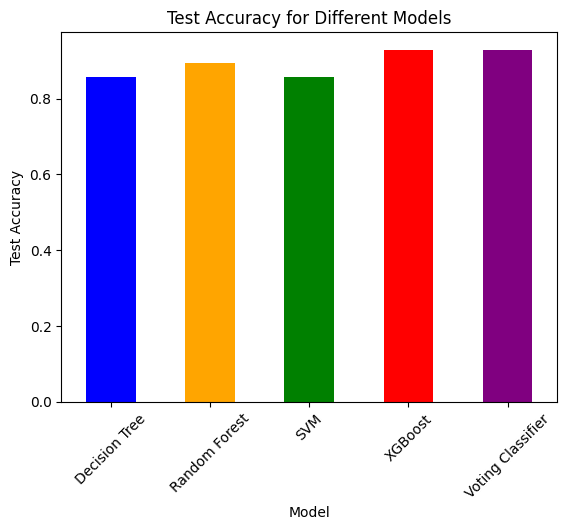

<Figure size 1000x600 with 0 Axes>

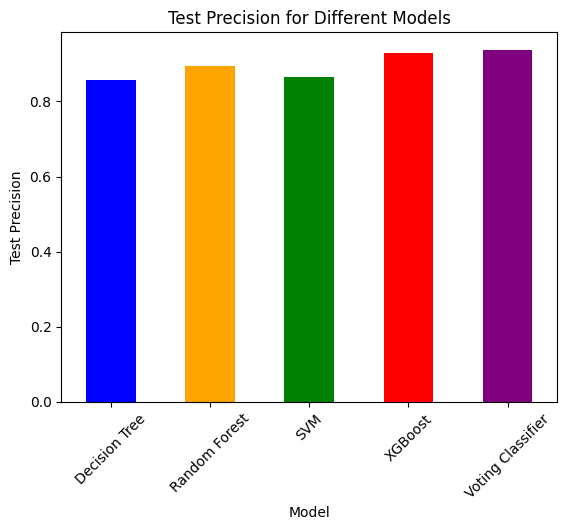

<Figure size 1000x600 with 0 Axes>

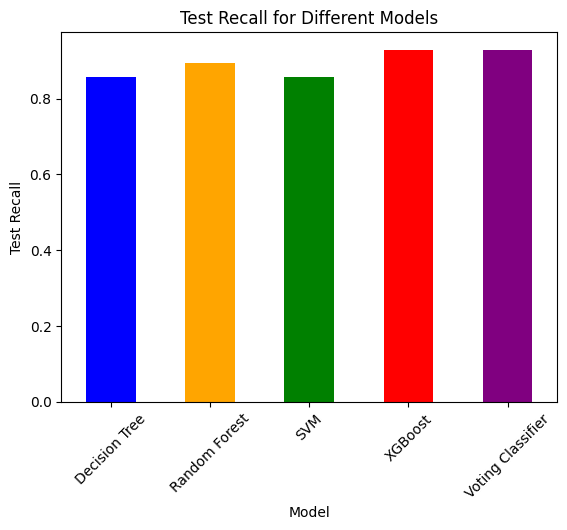

<Figure size 1000x600 with 0 Axes>

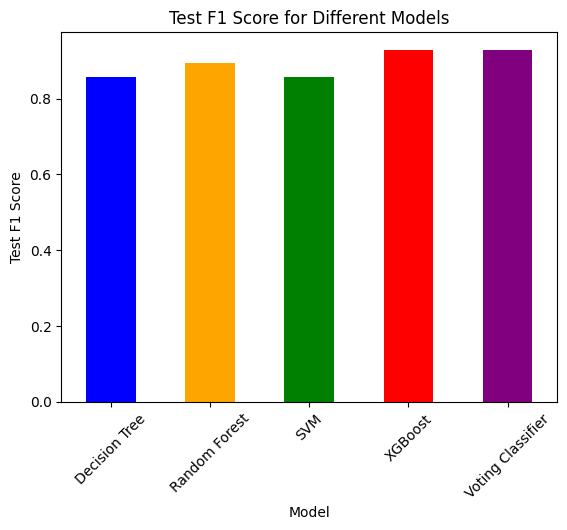

In [572]:
results_df = pd.DataFrame(results_dict)

for metric in ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score']:
    plt.figure(figsize=(10, 6))
    results_df.plot(x='Model', y=metric, kind='bar', color=['blue', 'orange', 'green', 'red', 'purple'], legend=False)
    plt.title(f'{metric} for Different Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

Sljedeće slike prikazuju matrice zabune izračunate nad ispitnim skupom podataka.

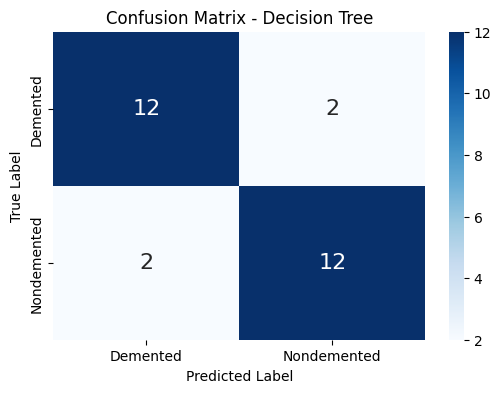

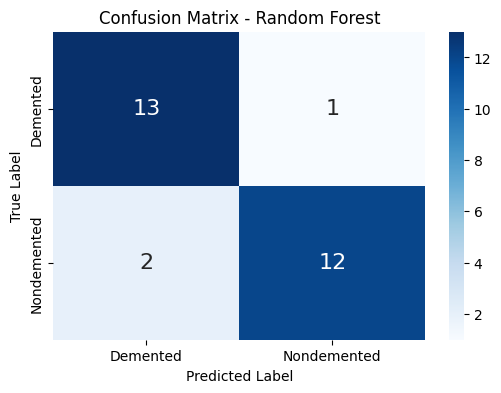

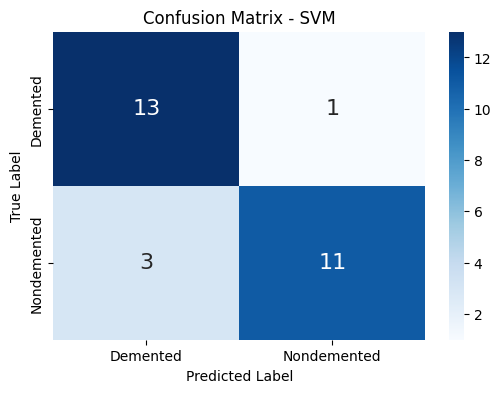

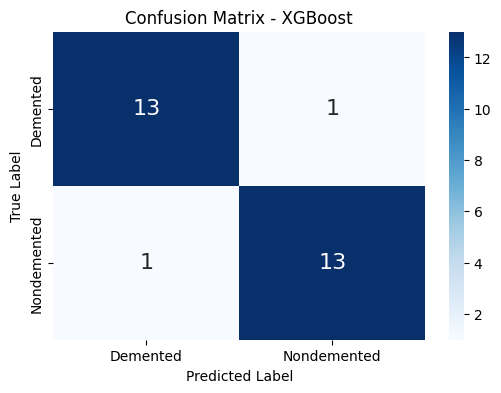

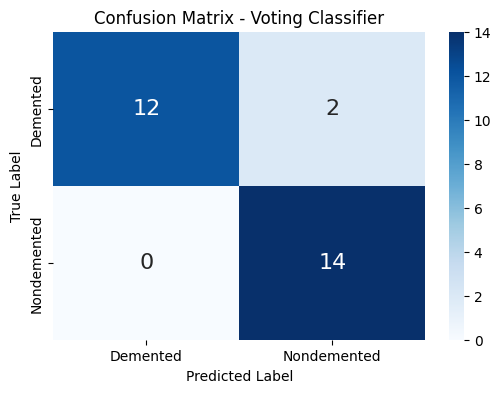

In [571]:
models = [dt_model, rf_model, svm_model, xgb_model, voting_model]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']

for model, name in zip(models, model_names):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)

    conf_matrix = confusion_matrix(Y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, xticklabels=['Demented', 'Nondemented'], yticklabels=['Demented', 'Nondemented'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\n")

Konačno, posljednji dijagrami prikazuju ROC/AUC krivulje za naših pet modela. Važno je napomenuti da površina ispod krivulje predstavlja mjeru učinkovitosti tih modela.

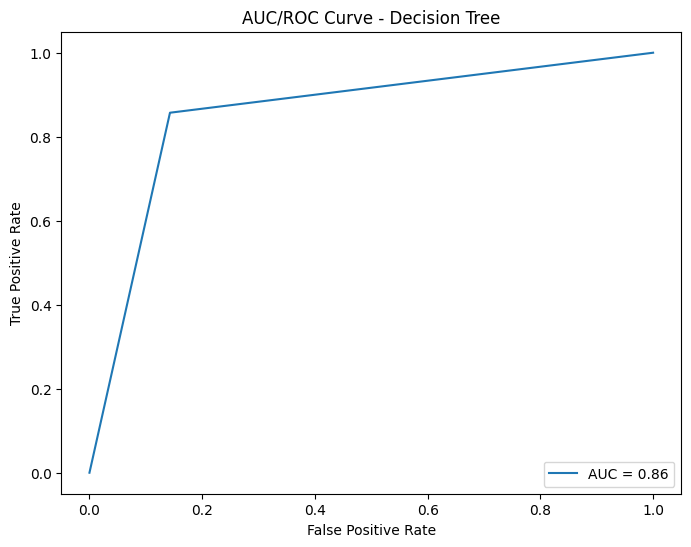

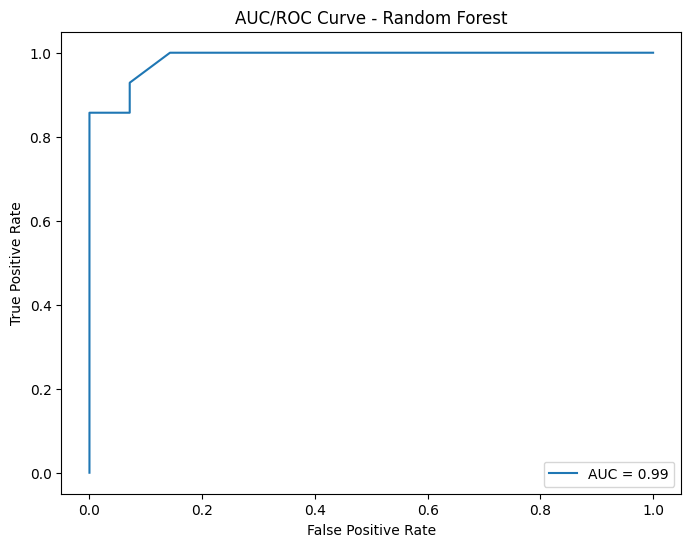

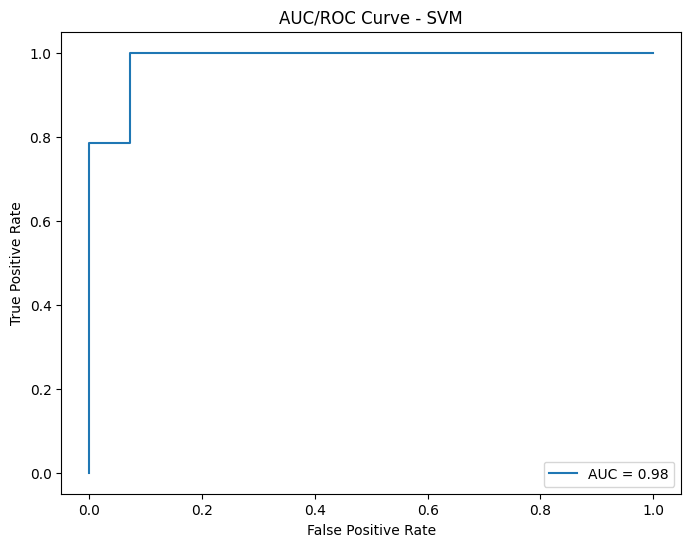

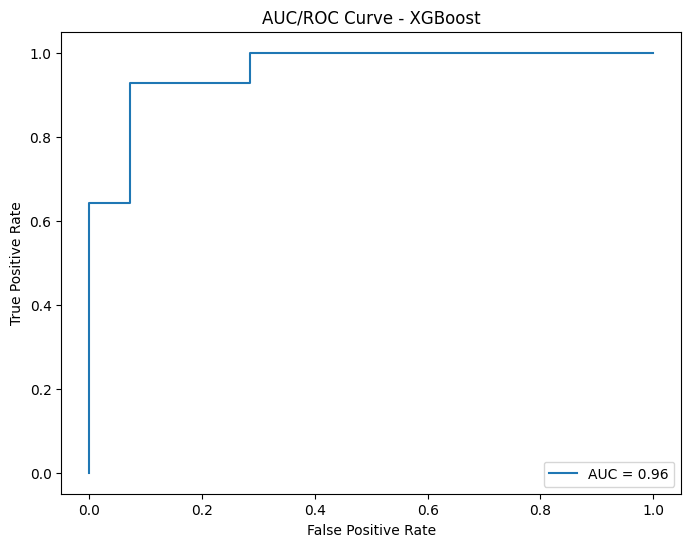

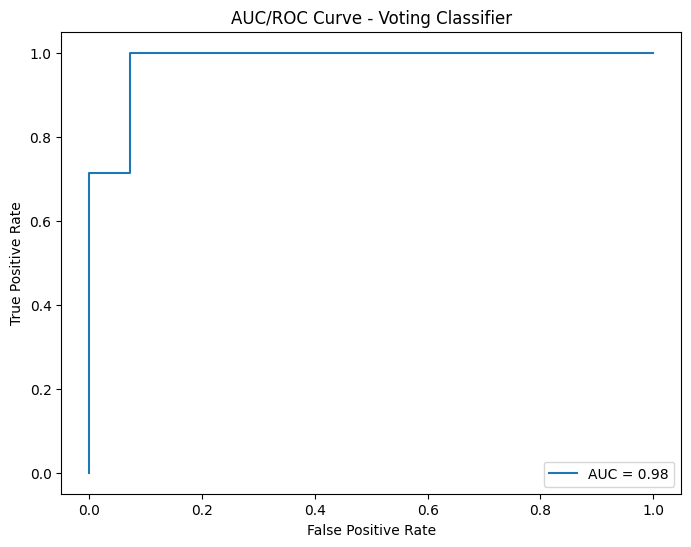

In [573]:
for model, name in zip(models, model_names):
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(Y_test, probabilities[:, 1])
        auc_value = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
        plt.title(f'AUC/ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()